In [27]:
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 

In [28]:
RANDOM_SEED = 42

In [29]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [30]:
max_val = np.float32(np.max(x_train[0]))

x_train = np.divide(x_train, max_val)
x_test = np.divide(x_test, max_val)

In [31]:
np.max(x_train[0])

np.float32(1.0)

In [32]:
y_train.shape

(60000,)

In [33]:
# convert data type from numpy arrays to tensors 
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
x_test = tf.convert_to_tensor(x_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.int32)

type(x_train)

2025-07-20 14:52:02.798370: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2025-07-20 14:52:02.942132: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


tensorflow.python.framework.ops.EagerTensor

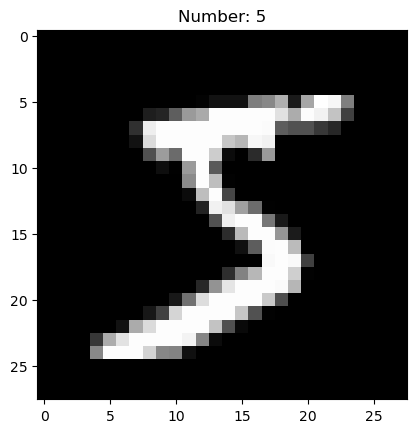

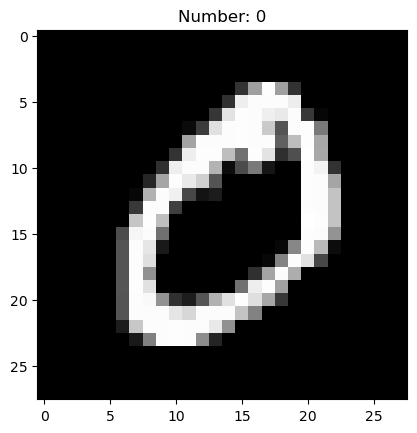

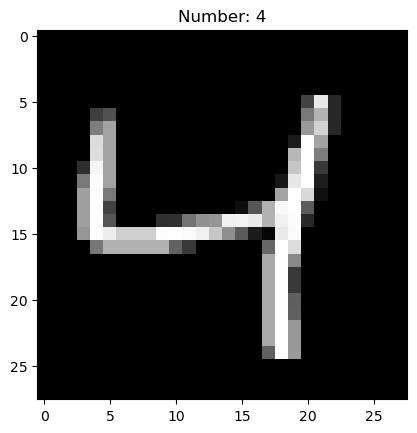

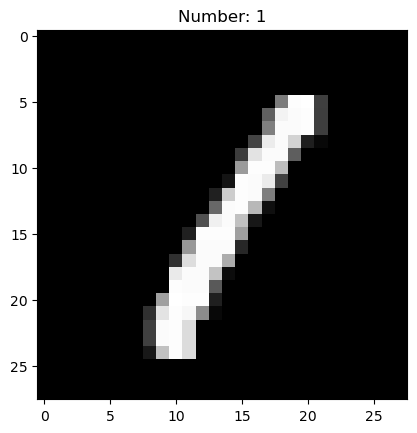

In [34]:
# plot some examples 

for i in range(4):
    plt.imshow(x_train[i], cmap='gray')
    plt.title(f"Number: {y_train[i]}")
    plt.show()

## Let's build a 3 layers neural network 

In [35]:
def parameters_initialization(layers_dims):
    parameters = {}
    he_initializer = tf.keras.initializers.HeNormal(seed=RANDOM_SEED)
    glorot_initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_SEED)
    for l in range(1, len(layers_dims)): 
        if l == len(layers_dims) - 1:
            initializer = glorot_initializer
        else: 
            initializer = he_initializer
        


        parameters['W' + str(l)] = tf.Variable(
            initializer(shape=(layers_dims[l], layers_dims[l-1])), 
            dtype=tf.float32
        )
        parameters['b' + str(l)] = tf.Variable(
            tf.zeros(shape=(layers_dims[l], 1)), 
            dtype=tf.float32
            )

    return parameters

In [36]:
def forward_prop(X, parameters):
    L = len(parameters) // 2
    cache = {}
    A_prev = tf.transpose(X) 
    for l in range(L-1): 
        Z = tf.math.add(tf.linalg.matmul(parameters['W' + str(l+1)], A_prev), parameters['b' + str(l+1)])
        A_prev = tf.keras.activations.leaky_relu(Z)
        cache['A' + str(l+1)] = A_prev

    ZL = tf.math.add(tf.linalg.matmul(parameters['W' + str(L)], A_prev), parameters['b' + str(L)])
    AL = tf.keras.activations.softmax(ZL, axis=0)

    cache['Z' + str(L)] = ZL
    cache['A' + str(L)] = AL

    
    return tf.transpose(AL), cache


In [37]:
def compute_total_loss(logits, labels): 
    
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            y_true=labels,
            y_pred=logits,
            from_logits=False
        )
    )
    return loss 

In [38]:
new_x_train = tf.reshape(x_train, shape=[x_train.shape[0], -1])
new_x_test = tf.reshape(x_test, shape=[x_test.shape[0], -1])


new_x_train.shape, new_x_test.shape 

(TensorShape([60000, 784]), TensorShape([10000, 784]))

In [39]:
new_y_train = y_train
new_y_test = y_test

In [40]:
# convert my training dataset to min-batches  :
def generate_mini_batches(X, y, minibatch_size):
    minibatch_size = 64
    m = float(len(X))
    minibatches = []
    num = int(m / minibatch_size)
    for k in range(num): 
        minibatch = (X[k * minibatch_size:(k+1) * minibatch_size],
                     y[k * minibatch_size:(k+1) * minibatch_size])

        minibatches.append(minibatch)
    if m / minibatch_size != 0: 

        minibatches.append((X[num * minibatch_size: ], y[num * minibatch_size: ]))

    return minibatches

In [52]:
def model(X_train, y_train, layers_dims, learning_rate=0.1, 
          num_epochs = 10, print_cost = True):

    costs = []
    train_acc = []

    parameters = parameters_initialization(layers_dims)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    train_accuracy = tf.keras.metrics.CategoricalAccuracy()

    m = len(X_train)

    batch_size = 64
    train_minibatches = generate_mini_batches(X_train, y_train, batch_size)

    for epoch in range(num_epochs): 

      epoch_total_loss = 0 
      train_accuracy.reset_state()

      for (minibatch_X, minibatch_y) in train_minibatches: 

            with tf.GradientTape() as tape: 

                  AL, _ = forward_prop(minibatch_X, parameters)

                  minibatch_total_loss = compute_total_loss(AL, minibatch_y)

            train_accuracy.update_state(minibatch_y, AL)


            grads = tape.gradient(minibatch_total_loss, list(parameters.values()))
            optimizer.apply_gradients(zip(grads, list(parameters.values())))
            epoch_total_loss += minibatch_total_loss

      epoch_total_loss /= m
      costs.append(epoch_total_loss)
      if print_cost == True: 
            print("Cost after epoch %i: %f" % (epoch+1, epoch_total_loss))
            print("Train accuracy:", train_accuracy.result())
    return parameters, costs, train_acc  



    



In [42]:
new_x_train.shape

TensorShape([60000, 784])

In [43]:
layers_dims = [784, 128, 64, 10]

In [44]:
X = new_x_train[:10000]
y = new_y_train[:10000]

In [48]:
y.shape, X.shape


(TensorShape([10000]), TensorShape([10000, 784]))

In [53]:
parameters, costs, train_acc = model(
    X, y, layers_dims, learning_rate=0.1
)



Cost after epoch 1: 0.227012
Train accuracy: tf.Tensor(0.0642, shape=(), dtype=float32)
Cost after epoch 2: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
Cost after epoch 3: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
Cost after epoch 4: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
Cost after epoch 5: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
Cost after epoch 6: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
Cost after epoch 7: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
Cost after epoch 8: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
Cost after epoch 9: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
Cost after epoch 10: 0.228348
Train accuracy: tf.Tensor(0.064, shape=(), dtype=float32)
